In [1]:
import math
import random
import time
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import Statevector, entropy, DensityMatrix
from qiskit_aer import AerSimulator

# Input:
 Constants epsilon, δ, Λ ∈ (0, 1), and copies of state ρ ∈ C2n×2n .

In [2]:
def generate_vector_state(ev_delta, n):
    if ev_delta < 0 or ev_delta > 1 / (2**n)**0.5:
        raise ValueError("ev_delta too large for normalization")
    dim = 2**n
    EV = [random.uniform(ev_delta, 1) for _ in range(dim)]
    norm = math.sqrt(sum(x**2 for x in EV))
    EV = [x/norm for x in EV]
    return EV

In [3]:
# This is problematic because initializing a mixed density matrix is not trivial. Maybe I will implement it later.
def generate_rho(ev_delta, n):
	if ev_delta > 1:
		raise ValueError("ev_delta must be less than or equal to 1")
	dim = pow(2,n)
	EV = []
	for i in range(dim):
		if sum(EV) <= 1 - ev_delta:
			phi_ev = random.uniform(ev_delta, 1-sum(EV))
			if 1-sum(EV)-phi_ev-ev_delta < 0 or i==dim-1:
				phi_ev = 1.0-sum(EV)
			EV.append(phi_ev)
		else:
			EV.append(0.0)
	EV = EV
	rho = np.diag(EV)

	Z = np.random.randn(dim, dim) + 1j*np.random.randn(dim, dim)
	R, _ = np.linalg.qr(Z)

	rho = R @ rho @ R.conj().T
	return rho

# Helpful functions
Compute coefficients L, K, Ml, and b(k)  l as given in Lemma 1.

In [5]:
# Calculating blk
def get_B(K, L):
	bkl_matrix = []
	for k in range(1, K + 1):
		bl_array = []
		for l in range(math.floor(L)+1):
			if k == 1:
				if l%2 == 0:
					blk = 0.0
				else:
					blk = 2 * math.comb(l-1,int((l-1)/2))/(math.pi*math.pow(2,l-1)*l)
				bl_array.append(blk)
			else:
				blk = 0.0
				for l_prime in range(l+1):
					blk += bkl_matrix[k-2][l_prime]*bkl_matrix[0][l-l_prime]
				bl_array.append(blk)

		bkl_matrix.append(bl_array)

	return bkl_matrix

def get_t(s, l):
	return (2*s-l)*math.pi/2

def get_f(s,l):
	k_sum= 0
	for k in range(1,K+1):
		k_sum += B[k-1][l]/k
	return k_sum*math.comb(l,s)/math.pow(2,l)

def get_Q(s,l,error):
	Q = math.ceil((2*s-l)**2*math.pi**2/(4*error))
	return Q


## Step 5
Define a distribution as in Eq. (32).

In [6]:
class ImportanceSampling:
	def __init__(self, rho, D, U, F_norm):
		self.samples = []
		current_max = 0
		for l in range(math.floor(L)+1):
			for s in range(D[l],U[l]+1):
				R = np.trace(rho*np.cos(rho*(2*s-l)*math.pi/2))
				prob_density = get_f(s,l)/F_norm
				current_max += prob_density
				data = [current_max, R, s, l]
				self.samples.append(data)

	def generate_sample(self):
		rand_val = random.uniform(0,1)
		for i in range(len(self.samples)):
			if rand_val <= self.samples[i][0]:
				return self.samples[i]

## Quantum subcircuits
### 1. Select subcircuit

In [8]:
def select_subcircuit(qc_s, qc_m, rho_pair1, rho_pair2, deltat):
	sub = QuantumCircuit(qc_m, qc_s, rho_pair1, rho_pair2, name="swap_block")
	sub.ccx(qc_m,qc_s[0],qc_s[1])

	# sub.barrier(rho_pair1, rho_pair2, label="Swap")

	for i in range(rho_pair1.size):
		sub.cx(rho_pair2[i], rho_pair1[i])
		sub.ccx(qc_s[1],rho_pair1[i],rho_pair2[i])
		sub.cx(rho_pair2[i], rho_pair1[i])

	# sub.barrier(rho_pair1, rho_pair2, label="Swap")

	sub.ccx(qc_m,qc_s[0],qc_s[1])
	sub.cs(qc_m,qc_s[0])
	if deltat > 0:
		sub.cz(qc_m,qc_s[0])

	return sub

def select_swap(mother_circ, qc_s, qc_m, rho_pair1, rho_pair2, deltat, inverse = False):
	swap_block = select_subcircuit(qc_s, qc_m, rho_pair1, rho_pair2, deltat)
	mother_circ.append(swap_block, mother_circ.qubits) if not inverse else mother_circ.append(swap_block.inverse(), mother_circ.qubits)

### 2. Initialize controlled statevector

In [9]:
def controlled_statevector_subcircuit(control_qbit, target_qbit, statevector, control_state, label=""):
	sub = QuantumCircuit(2, name=f"Controlled_{label}")
	init_gate = Initialize(statevector)
	gate = init_gate.gates_to_uncompute().to_gate()
	gate.label = label
	c_gate = gate.control()
	if control_state == 1:
		sub.append(c_gate, [0, 1])
	elif control_state == 0:
		sub.x(0)
		sub.append(c_gate, [0, 1])
		sub.x(0)
	else:
		raise ValueError("control_state must be 0 or 1")
	return sub

def apply_controlled_statevector(mother_circ, control_qbit, target_qbit, statevector, control_state, label="", inverse = False):
	statevector_block = controlled_statevector_subcircuit(control_qbit, target_qbit, statevector, control_state, label)
	mother_circ.append(statevector_block, [control_qbit,target_qbit]) if not inverse else mother_circ.append(statevector_block.inverse(), [control_qbit,target_qbit])

### 3. Swap operation exponentiation

In [10]:
def w_module_circuit(qc_s, qc_m, rho_copies, deltat):
	sub = QuantumCircuit(qc_m, qc_s, *rho_copies, name="W_module")
	alpha = math.cos(deltat)+math.fabs(math.sin(deltat))
	if alpha >=2:
		raise ValueError("alpha must be less than or equal to 2")
	r1 = [alpha/2, math.sqrt(1-alpha**2/4)]
	r2 = [math.sqrt(math.cos(deltat)/alpha), math.sqrt(math.sin(deltat)/alpha)]

	apply_controlled_statevector(sub, qc_m, qc_s[0], r1, 1, "R1")
	apply_controlled_statevector(sub, qc_s[0], qc_s[1], r2, 0, "R2")

	rho_pair1 = rho_copies[0]
	rho_pair2 = rho_copies[1]
	# sub.barrier(label="Controlled_Swap")
	select_swap(sub, qc_s, qc_m, rho_pair1, rho_pair2, deltat)
	# sub.barrier(label="Controlled_Swap")

	init_gate = Initialize(r2)
	dagger_gate = init_gate.gates_to_uncompute().to_gate().inverse()
	dagger_gate.label = "R2_dagger"
	sub.append(dagger_gate, [qc_s[1]])

	return sub

def apply_w_circuit(mother_circ, qc_s, qc_m, rho_copies, deltat, inverse=False):
	w_block = w_module_circuit(qc_s, qc_m, rho_copies, deltat)
	mother_circ.append(w_block, mother_circ.qubits) if not inverse else mother_circ.append(w_block.inverse(), mother_circ.qubits)

### 4. Swap exponentiation

In [11]:
def swap_exponentiation(qc_s, qc_m, rho_copies, deltat):
	sub = QuantumCircuit(qc_m, qc_s, *rho_copies, name="  Controlled e^(-iSΔt)  ")
	sub.label = "e^(-iSΔt)"

	# sub.barrier(label="Controlled_W")
	apply_w_circuit(sub, qc_s, qc_m, rho_copies, deltat)
	# sub.barrier(label="Controlled_W")

	sub.x(qc_s[0])
	sub.cz(qc_m,qc_s[0])
	sub.ccz(control_qubit1=qc_m,control_qubit2=qc_s[0],target_qubit=qc_s[1])
	sub.x(qc_s[0])

	# sub.barrier(label="Controlled_W_dagger")
	apply_w_circuit(sub, qc_s, qc_m, rho_copies, deltat, inverse = True)
	# sub.barrier(label="Controlled_W_dagger")

	sub.cz(qc_m,qc_s[0])
	sub.x(qc_s[0])
	sub.ccz(control_qubit1=qc_m,control_qubit2=qc_s[0],target_qubit=qc_s[1])
	sub.x(qc_s[0])

	# sub.barrier(label="Controlled_W")
	apply_w_circuit(sub, qc_s, qc_m, rho_copies, deltat)
	# sub.barrier(label="Controlled_W")

	return sub

def apply_swap_exponentiation(mother_circ, qc_s, qc_m, rho_copies, deltat, inverse=False):
	swap_exp_block = swap_exponentiation(qc_s, qc_m, rho_copies, deltat)
	mother_circ.append(swap_exp_block, mother_circ.qubits) if not inverse else mother_circ.append(swap_exp_block.inverse(), mother_circ.qubits)

## Function for step 12

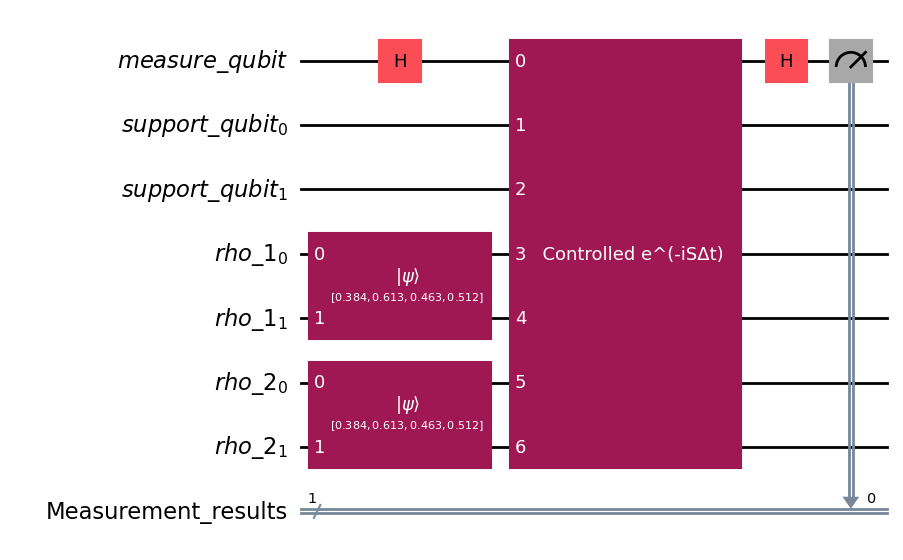

In [12]:
def quantum_circuit(qstate, Q, deltat):
	num_rho_size = qstate.num_qubits

	qc_m = QuantumRegister(1, name="measure_qubit")
	qc_s = QuantumRegister(2, name="support_qubit")

	rho_copies = []
	for i in range(2):
		rho_copies.append(QuantumRegister(num_rho_size, name=f"rho_{i+1}"))

	creq = ClassicalRegister(1, name="Measurement_results")
	qc = QuantumCircuit(qc_m, qc_s, *rho_copies, creq, name="Von_Neumann_Entropy")

	qc.initialize(qstate, rho_copies[0], normalize=True)

	qc.h(qc_m)

	for i in range(1,Q+1):
		qc.initialize(qstate, rho_copies[1], normalize=True)
		apply_swap_exponentiation(qc, qc_s, qc_m, rho_copies, deltat)

	qc.h(qc_m)
	qc.measure(qc_m,creq)
	return qc

Q = 1
deltat = 0.4
ev_delta = 0.2
n = 2
qstate = generate_vector_state(ev_delta, n)
qstate = Statevector(qstate)
qc = quantum_circuit(qstate, Q, deltat)
qc.draw("mpl")
# qc.decompose(reps=2).draw("mpl")
# step1 = qc.decompose(gates_to_decompose=['swap_exponentiation_block', 'swap_exponentiation_block_dg'])
# step2 = step1.decompose(gates_to_decompose=['Controlled_R1','Controlled_R2', 'swap_block'])
# step2.draw('mpl')
# qc.decompose(reps=100).draw('mpl')

# Full algorithm

In [13]:
epsilon = 0.2
delta = 0.2
deltat = 0.1
ev_delta = 0.2
n = 1
# rho = generate_rho(ev_delta, n)
# print(rho)
qstate = generate_vector_state(ev_delta, n)
qstate = Statevector(qstate)
rho = qstate.to_operator().data


K = math.ceil(np.log(epsilon*ev_delta)/np.log(1-ev_delta))
l_part = 0
for i in range(1,K+1):
	l_part += 1/i
l_part = 4 * l_part / epsilon
L = math.log1p(l_part) * 1 / (ev_delta * ev_delta)
M = []
for l in range(math.floor(L)+1):
	Ml = math.ceil(math.sqrt(math.log1p(l_part)*l/2))
	M.append(Ml)

B = get_B(K, L)

U = []
for l in range(math.floor(L+1)):
	Ul = min(l,math.ceil(L/2)+M[l])
	U.append(Ul)

D = []
for l in range(math.floor(L+1)):
	Dl = max(0, math.floor(l/2)-M[l])
	D.append(Dl)

def get_t(s, l):
	return (2*s-l)*math.pi/2

F = np.array([])
for l in range(math.floor(L)+1):
	for s in range(D[l],U[l]+1):
		f = get_f(s,l)
		F = np.append(F, f)

F_norm = np.linalg.norm(F, ord = 1)
error = epsilon/F_norm

N = 0
for l in range(math.floor(L)-1):
	N += 2*M[l]+1

importance_sampler = ImportanceSampling(rho, D, U, F_norm)
B_n_samples = round((F_norm/epsilon)**2*np.log(2/delta))

B_samples = []
for b in range(1,B_n_samples+1):
	sample = importance_sampler.generate_sample()
	B_samples.append(sample)

C:\Users\adria\miniconda3\envs\A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\adria\miniconda3\envs\A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization\Lib\site-packages\numpy\lib\_histograms_impl.py:853: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
C:\Users\adria\miniconda3\envs\A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization\Lib\site-packages\numpy\lib\_histograms_impl.py:896: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
C:\Users\adria\miniconda3\envs\A-Practical-Guide-to-Quantum-Machine-Learning-and-Quantum-Optimization\Lib\site-packages\matplotlib\axes\_axes.py:7135: ComplexWarning: Casting complex values to real discards the

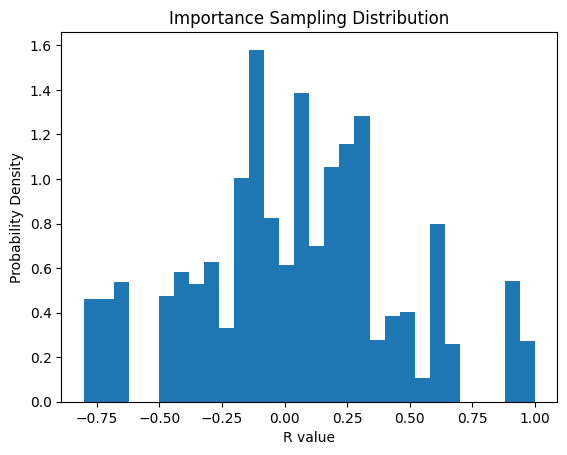

In [14]:
sample = importance_sampler.generate_sample()
R_values = [s[1] for s in importance_sampler.samples]

plt.hist(R_values, bins=30, density=True)
plt.xlabel("R value")
plt.ylabel("Probability Density")
plt.title("Importance Sampling Distribution")
plt.show()

In [15]:
print(qstate)
von_n_entropy = entropy(qstate)
print(f"Von Neumann Entropy of the state is {von_n_entropy}")

Statevector([0.77752554+0.j, 0.62885136+0.j],
            dims=(2,))
Von Neumann Entropy of the state is 0


In [ ]:
sim = AerSimulator()

j = 0
total_sum = 0
print(f"Number of B_n_samples: {B_n_samples}")
print("=====================================")

for j in tqdm(range(B_n_samples), desc='Completed runs'):
	B_data = B_samples[j]
	Q = get_Q(s=B_data[2],l=B_data[3],error=error)

	qc = quantum_circuit(qstate, Q, deltat)
	qc_decomp = qc.decompose(reps=10)
	print(f"Quantum circuit decomposed. Circuit depth: {qc_decomp.depth()}")

	start = time.time()
	compiled_qc = transpile(qc_decomp, sim, optimization_level=1)
	total = time.time() - start

	print(f"Compilation complete. Total time taken: {round(total,2)}s")

	job = sim.run(compiled_qc, shots=1024)
	counts = job.result().get_counts()
	est = math.fabs(counts.get("0", 0) / 1024 - counts.get("1", 0) / 1024)

	total_sum += est

print("=====================================")
von_neumann_entropy_est = F_norm*total_sum/B_n_samples
print(f"Estimated Von Neumann Entropy is {von_neumann_entropy_est}. Actual Von Neumann Entropy is {von_n_entropy}" )


Number of B_n_samples: 390


Completed runs:   0%|          | 0/390 [00:00<?, ?it/s]

Quantum circuit decomposed. Circuit depth: 22578
Compilation complete. Total time taken: 3.44s


Completed runs:   0%|          | 1/390 [00:14<1:33:55, 14.49s/it]